In [1]:
%matplotlib inline

import gym
import matplotlib
import numpy as np
import sys

from collections import defaultdict
if "../" not in sys.path:
  sys.path.append("../") 
from lib.envs.blackjack import BlackjackEnv
from lib import plotting

matplotlib.style.use('ggplot')

In [2]:
env = BlackjackEnv()

In [3]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    def policy_fn(observation):
        A = np.ones(nA, dtype=float) * epsilon / nA
        best_a = np.argmax(Q[observation])
        A[best_a] += (1.0 - epsilon)
        return A
    return policy_fn

In [17]:
def mc_control_epsilon_greedy(env, num_episodes, discount_factor=1.0, epsilon=0.1):
    # Keeps track of sum and count of returns for each state
    # to calculate an average. We could use an array to save all
    # returns (like in the book) but that's memory inefficient.
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    gamma = discount_factor
    
    for episode in range(1, num_episodes + 1):

        episodes = []
        s = env.reset()
        done = False
        while done == False:
            p = policy(s)
            a = np.random.choice(np.arange(len(p)), p=p)
            future_s, r, done, _ = env.step(a)
            episodes.append((s, a, r))

        sa_in_episode = set([(tuple(x[0]), x[1]) for x in episodes])
        for s, a in sa_in_episode:
            sa_pair = (s, a)
            first_visit_i = next(i for i,x in enumerate(episodes) if x[0] == s and x[1] == a)
            G = sum([x[2]*(gamma**i) for i,x in enumerate(episodes[first_visit_i:])])
            returns_sum[sa_pair] += G
            returns_count[sa_pair] += 1.0
            Q[s][a] = returns_sum[sa_pair] / returns_count[sa_pair]
    
    return Q, policy

In [18]:
Q, policy = mc_control_epsilon_greedy(env, num_episodes=500000, epsilon=0.1)

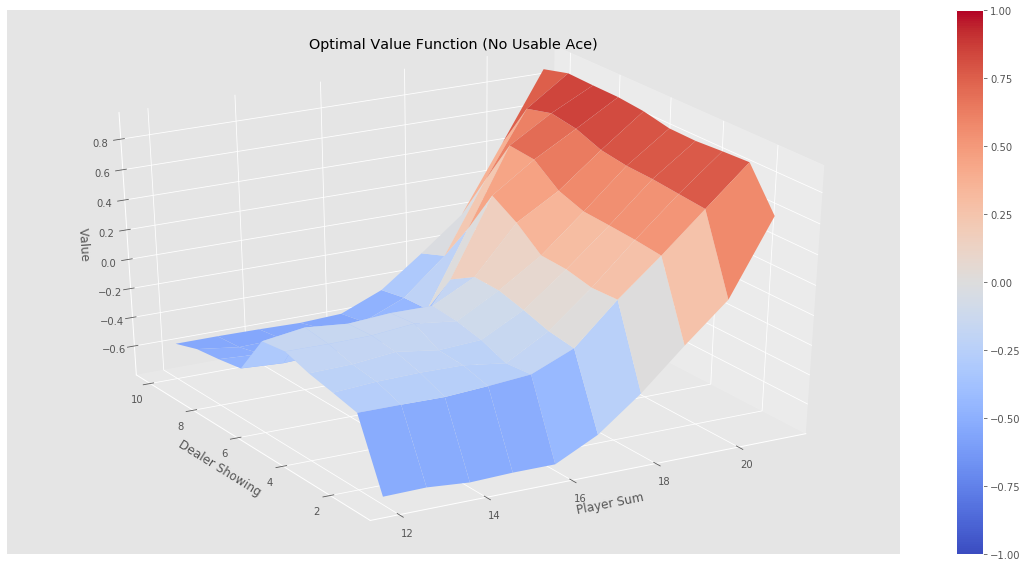

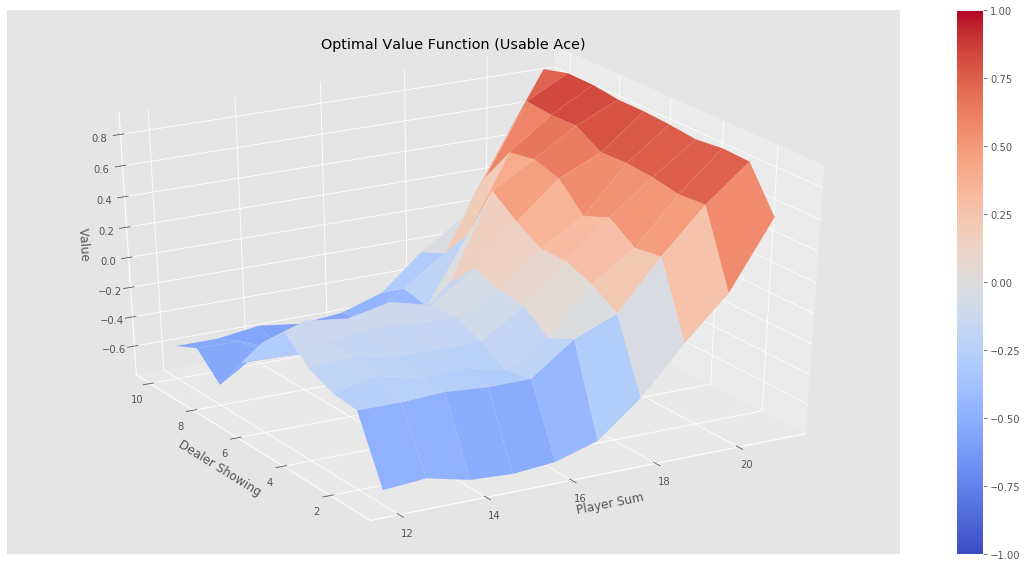

In [19]:
# For plotting: Create value function from action-value function
# by picking the best action at each state
V = defaultdict(float)
for state, actions in Q.items():
    action_value = np.max(actions)
    V[state] = action_value
plotting.plot_value_function(V, title="Optimal Value Function")